## LangGraph with Tavily

In [1]:
import os
import json

from pydantic import BaseModel, Field, HttpUrl
from typing import TypedDict, Annotated, List, Literal, Optional, Any, Dict, Annotated
import operator
from operator import itemgetter
from dataclasses import dataclass, field

from langchain_google_genai import ChatGoogleGenerativeAI
import google.generativeai as genai
from google.genai import types

from tavily import TavilyClient

from langgraph.graph import StateGraph, MessagesState,START, END


from IPython.display import Image

## Configuring API KEYS

In [2]:
google_api_key = "<API_KEY>"
tavily_api_key = "<API_KEY>"
    
os.environ["GEMINI_API_KEY"] = google_api_key
os.environ["TAVILY_API_KEY"] = tavily_api_key
genai.configure(api_key=google_api_key)
tavily_client = TavilyClient(api_key=os.environ.get("TAVILY_API_KEY"))

## Prompts

In [3]:
search_questions_system_prompt = """ROLE:
You are an analytical assistant specialized in expanding vague user queries into multiple web-searchable, insight-rich questions.

STRICT INSTRUCTION: STRICTLY RESPOND ONLY WITH THE FINAL LIST OF QUESTIONS IN THE GIVEN FORMAT
MAIN OBJECTIVE:
Transform the given user query into a structured list of 5 distinct and meaningful questions that explore the topic from diverse analytical perspectives.

<INPUT_USER_QUERY>
{user_query}
<INPUT_USER_QUERY_END>

CONTEXT:
The analysis focuses on competitive clothing retail markets and supports the following stakeholders:
1. Business Owners & Managers – Interested in competitors, customer behavior, and peak hours.
2. Marketing & Strategy Teams – Focused on promotions, footfall trends, and campaign performance.
3. Real Estate & Location Analysts – Concerned with store placement, local traffic flow, and expansion opportunities.
4. Investors & Market Analysts – Evaluating profitability, market saturation, and risk outlook.

GUIDELINES:
- Generate **exactly 5** self-contained, web-search-ready questions.
- Each question should explore the topic from a unique angle such as:
  - Competitive intelligence  
  - Consumer behavior and timing  
  - Local market dynamics  
  - Location and footfall analysis  
  - Investment outlook or trend prediction  
- Avoid vague or repetitive phrasing.
- Ensure each question can be independently used for online search.

EXPECTED OUTPUT FORMAT (strictly adhere to this schema):

{{
  "listOfQuestions": [
    {{"question": "<Question 1>"}},
    {{"question": "<Question 2>"}},
    {{"question": "<Question 3>"}},
    {{"question": "<Question 4>"}},
    {{"question": "<Question 5>"}}
  ]
}}

Ensure the output is a **valid JSON object** compatible with the following Pydantic schema:

class question(BaseModel):
    question: str = Field(..., description="Individual questions from the output")

class listOfQuestions(BaseModel):
    listOfQuestions: list[question] = Field(..., description="List of various questions")

EXAMPLE INPUT:
USER QUERY: "How do clothing stores in Koramangala perform?"

EXAMPLE OUTPUT:
{{
  "listOfQuestions": [
    {{"question": "What are the top-performing clothing stores in Koramangala, and what factors contribute to their success?"}},
    {{"question": "How do footfall trends vary by time of day or week for fashion retailers in Koramangala?"}},
    {{"question": "Which marketing strategies are most effective for clothing stores in competitive areas like Koramangala?"}},
    {{"question": "How does store location within Koramangala affect sales and customer engagement for apparel businesses?"}},
    {{"question": "What is the investment outlook for retail apparel businesses in Bangalore’s Koramangala district?"}}
  ]
}}
"""

summary_system_prompt = """
You are an intelligent assistant tasked with answering user queries based on relevant web search results.

<User Query>
{user_query}
</User Query>

Use the following web search results to provide an accurate, complete, and contextually relevant response. Integrate information across sources, summarize key points, and ensure clarity in your explanation.

<Context>
<CONTEXT>
</Context>

Guidelines:
- Your presentation should be in a executive report format
- Leverage information from context if any
- Highlight key insights, trends, or actionable points if applicable.
- Present your answer in a clear, structured, and concise manner.

Intended Beneficiaries
This solution will benefit the following groups:
1. Business Owners and Managers
Clothing store owners or managers in areas with high competition can use this report to
identify key competitors, analyze peak customer hours, and adjust their own strategies to
improve market position.
2. Marketing and Strategy Teams
Marketing teams responsible for local engagement can leverage insights on footfall trends to
optimize promotions during high-traffic periods. Additionally, competitive data can help
strategists shape targeted campaigns, aligning with or counteracting competitor timings.
3. Real Estate and Location Analysts
Location-based data on competitor footfall and busy hours can also assist analysts in
recommending ideal store locations for future openings, as well as identifying high-value
times for new store launches.
4. Investors and Market Analysts
Investors considering opportunities in retail can use competitor analysis to assess market
saturation, business potential, and potential risks in high-traffic areas like Koramangala,
Bangalore.
"""

class question(BaseModel):
    question: str = Field(..., description="Individual questions from the output")

class listOfQuestions(BaseModel):
    listOfQuestions: list[question] = Field(..., description="List of various questions")

## Declaring LangGraph State

In [4]:
class MarketAnalysisState(BaseModel):
    user_question: Annotated[str, operator.add] = None
    search_query:Annotated[str, operator.add] = None
    list_of_search_questions: Annotated[list, operator.add]  = []
    list_of_search_responses: Annotated[list, operator.add]  = []
    log_messages: Annotated[list, operator.add]  = []
    final_summary: Annotated[str, operator.add] = None

## Initial refinement of the user query into broader questions to be searched online

In [5]:
# get search questions
def get_search_questions(state: MarketAnalysisState):
    dynamic_data = {"user_query":state.user_question}
    search_questions_system_prompt.format(**dynamic_data)

    model = genai.GenerativeModel("gemini-2.0-flash")
    response = model.generate_content(
        summary_system_prompt
    )
    
    text = response.candidates[0].content.parts[0].text
    
    response2 = model.generate_content(
        "Extract the list of 5 questions in a form of a json list from the following text \n\n" + text,
    generation_config=genai.GenerationConfig(
            response_mime_type="application/json",
            response_schema=listOfQuestions,
        )
    )
    
    text2 = response2.candidates[0].content.parts[0].text
    data = json.loads(text2)
    questions = [q["question"] for q in data["listOfQuestions"]]
    state.list_of_search_questions = questions
    return state
    

## Tavily Search Tool & Final Executive summary

In [6]:
# online search needed?
def should_continue(state: MarketAnalysisState) -> bool:
    if len(state.list_of_search_questions)>0:
        return 'search_tool'
    else:
        return 'summary'
        
    
def search_tool(state: MarketAnalysisState):
    all_results = []
    
    # Collect results for all queries
    for query in state.list_of_search_questions:
        print(f"\n--- Searching Tavily for: '{query}' ---")
        search_query = state.user_question + query
        response = tavily_client.search(query=query, search_depth="advanced", max_results=2)
        results_summary = [
            f"Source: {r['url']}\nSnippet: {r['content']}" for r in response.get('results', [])
        ]
        if not results_summary:
            results_summary = ["No relevant search results found for the query."]
        
        all_results.append(results_summary)

    state.list_of_search_responses.extend(all_results)
    state.list_of_search_questions = []  
    
    return state

def summary(state: MarketAnalysisState):
    print(f"\n--- Final Summary preparation on the way: '{state.user_question}' ---")
    dynamic_data = {"user_query":state.user_question,
                   "context": '<NEW SEARCH RESULT>'.join([x[0] for x in state.list_of_search_responses]) }
    
    model = genai.GenerativeModel("gemini-2.0-flash")
    response = model.generate_content(
        summary_system_prompt.format(**dynamic_data)
    )
    state.final_summary = response.candidates[0].content.parts[0].text
    return state

## Creating the graph

In [7]:
graph = StateGraph(MarketAnalysisState)

# Only add your regular nodes
graph.add_node("get_search_questions", get_search_questions)
graph.add_node("search_tool", search_tool)
graph.add_node("summary", summary)

# Set entry point
graph.set_entry_point("get_search_questions")
graph.add_edge("get_search_questions", "search_tool")
graph.add_edge("search_tool", "summary")
graph.add_edge("summary", END)


## Visualizing the langraph orchestration

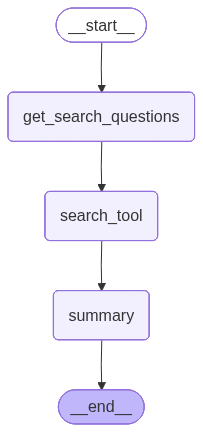

In [31]:
Image(app.get_graph().draw_mermaid_png())

## Executing the graph

In [25]:
app = graph.compile()

initial_state = MarketAnalysisState(
    user_question="How to approach marketing campaign for clothing stores in Koramangala?",
    log_messages=[]
)

final_state = app.invoke(initial_state)


--- Searching Tavily for: 'What are the key trends?' ---

--- Searching Tavily for: 'What are the competitive insights?' ---

--- Searching Tavily for: 'What are the potential opportunities for businesses, marketing teams, real estate analysts, and investors?' ---

--- Searching Tavily for: 'What are the implications for business owners and managers?' ---

--- Searching Tavily for: 'What are the implications for marketing and strategy teams?' ---

--- Final Summary preparation on the way: 'How to approach marketing campaign for clothing stores in Koramangala?How to approach marketing campaign for clothing stores in Koramangala?How to approach marketing campaign for clothing stores in Koramangala?How to approach marketing campaign for clothing stores in Koramangala?' ---


## Final Executive Summary

In [29]:
print(final_state['final_summary'])

Executive Report: Marketing Campaign Strategies for Clothing Stores in Koramangala

Introduction:
This report outlines strategies for developing effective marketing campaigns for clothing stores in Koramangala, Bangalore. Given the high competition and dynamic consumer behavior in this area, a targeted and data-driven approach is crucial for success. This report is designed to inform business owners, marketing teams, real estate analysts, and investors.

Key Strategies and Considerations:

1. Competitive Analysis:
   - Identify key competitors in Koramangala.
   - Analyze their marketing strategies, including online presence, promotions, and customer engagement tactics.
   - Understand their peak hours and footfall to identify opportunities and potential competitive advantages.

2. Target Audience Segmentation:
   - Define the target audience based on demographics, lifestyle, and fashion preferences.
   - Tailor marketing messages and channels to resonate with specific segments.
   - C

## Internal Langraph Responses

In [27]:
final_state

{'user_question': 'How to approach marketing campaign for clothing stores in Koramangala?How to approach marketing campaign for clothing stores in Koramangala?How to approach marketing campaign for clothing stores in Koramangala?How to approach marketing campaign for clothing stores in Koramangala?How to approach marketing campaign for clothing stores in Koramangala?How to approach marketing campaign for clothing stores in Koramangala?How to approach marketing campaign for clothing stores in Koramangala?How to approach marketing campaign for clothing stores in Koramangala?',
 'search_query': '',
 'list_of_search_questions': ['What are the key trends?',
  'What are the competitive insights?',
  'What are the potential opportunities for businesses, marketing teams, real estate analysts, and investors?',
  'What are the implications for business owners and managers?',
  'What are the implications for marketing and strategy teams?',
  'What are the key trends?',
  'What are the competitive